# Table of Contents

## Import Modules

Let's important modules for analysis, visualizations and modeling.

In [56]:
import numpy as np
import pandas as pd
from pymongo import MongoClient
import time
import re
import html
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from gensim import corpora, models, similarities, matutils
import logging

In [57]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Fetch Data from Database

I previously made a query to my MongoDB database to fetch all the Hacker News documents recorded. Once I had enough data, I pickled a dataframe to use for analysis. 

In [58]:
# client = MongoClient("mongodb:/{ip_address_for_mongo_server}/hacker_news_database")
# mydb = client.hacker_news_database  # names a database
# collection = mydb.hacker_news_collection  # refers to my collection
# data = pd.DataFrame(list(collection.find()))

Turn our observations (Hacker News posts/comments) into rows. Each key from an API request is seen here as a column with its corresponding value for each observation.

In [59]:
data = pd.read_pickle('three_hundred_K_hn_posts_df')

In [60]:
data.head()

,_id,by,dead,deleted,descendants,kids,parent,parts,poll,score,text,time,title,type,url
0,14170376,dragonwriter,NaN,NaN,NaN,[14170821],14169290.0,NaN,NaN,NaN,"Well, there&#x27;s an interesting, tangentiall...",1492819269,NaN,comment,NaN
1,14170375,uncensored,NaN,NaN,NaN,NaN,14170058.0,NaN,NaN,NaN,Substansively? Tons of replies are not substan...,1492819230,NaN,comment,NaN
2,14170374,supernumerary,NaN,NaN,NaN,"[14170677, 14170866, 14173394]",14168157.0,NaN,NaN,NaN,"Regarding chicago this: \n<a href=""https:&#x2F...",1492819229,NaN,comment,NaN
3,14170373,bobsil1,NaN,NaN,NaN,NaN,14169489.0,NaN,NaN,NaN,Parking lots we don&#x27;t need after autonomo...,1492819210,NaN,comment,NaN
4,14170372,thecrazyone,NaN,NaN,NaN,NaN,14168900.0,NaN,NaN,NaN,It&#x27;s good to have this as a general remin...,1492819202,NaN,comment,NaN


296,745 documents in our MongoDB collection

In [61]:
len(data.index)

296745

## Clean Data

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296745 entries, 0 to 296744
Data columns (total 15 columns):
_id            296745 non-null int64
by             287920 non-null object
dead           14071 non-null object
deleted        8824 non-null object
descendants    32306 non-null float64
kids           125967 non-null object
parent         253433 non-null float64
parts          4 non-null object
poll           11 non-null float64
score          41742 non-null float64
text           248388 non-null object
time           296745 non-null int64
title          41731 non-null object
type           296745 non-null object
url            39260 non-null object
dtypes: float64(4), int64(2), object(9)
memory usage: 34.0+ MB


We have 296,745 observations (Hacker News posts/comments)

In [63]:
data.index

RangeIndex(start=0, stop=296745, step=1)

I noticed the first few Hacker News posts contained characters not seen on the site. There were HTML tags and escape characters. We ought to remove them so they don't skew our natural language processing insights.

I noticed some text values appear as NaN values that are floats too.

In [64]:
df = data.dropna(subset=['text'])

In [65]:
def remove_html(hn_comment):
    """
    Convert all numeric character references like &gt and &#62 into corresponding unicode characters. 
    Remove HTML tags for paragraphs and italics.
    Source: https://docs.python.org/3/library/html.html
    """
    hn_comment = html.unescape(hn_comment)
    return hn_comment

Apply remove_html function to text column in our dataframe

In [66]:
df.text = df.text.apply(remove_html)

/Users/dan/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [67]:
df.head()

,_id,by,dead,deleted,descendants,kids,parent,parts,poll,score,text,time,title,type,url
0,14170376,dragonwriter,NaN,NaN,NaN,[14170821],14169290.0,NaN,NaN,NaN,"Well, there's an interesting, tangentially rel...",1492819269,NaN,comment,NaN
1,14170375,uncensored,NaN,NaN,NaN,NaN,14170058.0,NaN,NaN,NaN,Substansively? Tons of replies are not substan...,1492819230,NaN,comment,NaN
2,14170374,supernumerary,NaN,NaN,NaN,"[14170677, 14170866, 14173394]",14168157.0,NaN,NaN,NaN,"Regarding chicago this: \n<a href=""https://en....",1492819229,NaN,comment,NaN
3,14170373,bobsil1,NaN,NaN,NaN,NaN,14169489.0,NaN,NaN,NaN,Parking lots we don't need after autonomous cars.,1492819210,NaN,comment,NaN
4,14170372,thecrazyone,NaN,NaN,NaN,NaN,14168900.0,NaN,NaN,NaN,It's good to have this as a general reminder: ...,1492819202,NaN,comment,NaN


We still have HTML tags and \n in our comments. Let's use regex to remove them.

In [68]:
# wanted to pass parameter inplace=True but kept on getting an error; so making a copy instead
pattern = r"<.*?>"
replace = " "
df['text'] = df['text'].str.replace(pattern, replace)

/Users/dan/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [69]:
pattern = r"\n"
replace = " "
df['text'] = df['text'].str.replace(pattern, replace)

/Users/dan/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Create a dataframe just of the text comment values from HN posts. We'll start with NLP analysis of just these.

In [70]:
df_type_comments = df.loc[df.type == 'comment']

## Create Vector Space from Text

We want to derive meaning from the natural language of Hacker News comments. We must map the langauge to a vector space for analysis.

[Stemming](https://en.wikipedia.org/wiki/Stemming) allows us to reduce derived words to their word stem - aka base or root form.

"Amazon's catalog contains" -> "Amazon catalog contain"

Notice how the possessive form of Amazon was removed and the "s" ending in the word "contains."

[Lemmatization](https://en.wikipedia.org/wiki/Lemmatisation) is often viewed as the more powerful form of stemming. Lemming understands vocabulary and morphological analysis. Essentially, it removes inflectional endings to return the word to its base or dictionary form of a word, defined as the lemma.

[Sklearn doc on using Nltk Lemmatizer](http://scikit-learn.org/stable/modules/feature_extraction.html#customizing-the-vectorizer-classes)

In [71]:
class LemmaTokenizer(object):
    """
    References NLTK Lemmatization class and functionality to modify words in corpus
    """
    def __init__(self):
        self.wnl = WordNetLemmatizer()  # a call to NLTK
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]  # apply lematize for each word

The LemmaTokenizer may have caused some issue 

In [72]:
count_vectorizer = CountVectorizer(min_df=10,
                                   stop_words='english', 
                                   token_pattern='[a-z][a-z]+', 
                                   ngram_range=(1,2))
count_vect_matrix = count_vectorizer.fit_transform(df_type_comments.text)

TfidfVectorizer counts words in each document, and weights the counts relative to how those words appear across all documents.

- min_df=10 only includes words we've seen at least 10 times
- stop_words='english' exludes words that have very little semantic value (such as 'a', 'an', etc)
- token_pattern='[a-z][a-z]+' makes sure we only include alphabetical-based words, not numbers.
- ngram_range=(1,2) sets lower and upper boundary of n-values; for features we'll have words and 2-word phrases (aka bigrams)

We call fit_transform() on our data to transform our data into our new features into a dimensional space that corresponds to our parameters with Tfidf

[Sklearn documentation on TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [73]:
vectorizer = TfidfVectorizer(min_df = 10,
                             stop_words = 'english',
                             token_pattern = '[a-z][a-z]+',
                             ngram_range = (1,2))
X = vectorizer.fit_transform(df_type_comments.text)  # returns a Scipy sparse matrix

We have 83,175 features after our Tfidf vectorizer

In [74]:
len(vectorizer.get_feature_names())

83175

We want to reduce the number of features under consideration, while minimizing information loss in our data. We'll use dimensionality reduction to reduce the number of features, but create new ones that help explain the most variance in our data. The first principal component has the largest possible variance and each succeeding component in turn has the higest variance possible and uncorrelated with the preceding components. 

We use Truncated SVD (singular value decomposition through latent samentic analysis) because it works with sparse matrices efficiently. SVD works on Tfidf matrixes as well. 

[Sklearn documentation on TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

- n_components=40 examines first 40 principal components (latent semantic features)

In [75]:
X

<246175x83175 sparse matrix of type '<class 'numpy.float64'>'
	with 7508820 stored elements in Compressed Sparse Row format>

I want to see what our matrix decomposition looks like under the hood.

In [76]:
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(X, 
                              n_components=15,
                              n_iter=5,
                              random_state=None)

In [77]:
U

array([[ 0.00184738,  0.00022025,  0.00050301, ..., -0.00115457,
        -0.00234192,  0.00020745],
       [ 0.00083195, -0.00038486, -0.00026842, ...,  0.00496335,
        -0.00031413, -0.00135294],
       [ 0.00342035,  0.00406801,  0.00965432, ...,  0.00115994,
         0.00016543,  0.00089364],
       ..., 
       [ 0.00152403, -0.00050143, -0.0001921 , ..., -0.00035186,
        -0.00014684, -0.00037306],
       [ 0.0016524 , -0.00054557, -0.00039051, ..., -0.00282791,
        -0.00438656,  0.00125054],
       [ 0.00093931, -0.00042672, -0.00022989, ..., -0.00039535,
         0.00016842, -0.00048218]])

In [78]:
Sigma

array([ 38.19621221,  31.0574047 ,  25.62477408,  23.24427463,
        18.8195793 ,  18.30812046,  17.51070779,  16.95583995,
        16.66351314,  16.58736918,  15.52554755,  15.23777116,
        15.154738  ,  15.01380169,  14.83673161])

In [79]:
VT

array([[  1.06167549e-03,   9.15462554e-04,   1.78764062e-04, ...,
          4.45853518e-04,   2.24947076e-04,   1.20783508e-04],
       [  3.43585846e-04,  -3.70381319e-04,  -5.93248948e-05, ...,
          2.08787206e-05,  -2.85200863e-05,  -3.83400741e-05],
       [  7.41168100e-04,  -1.59251858e-04,  -1.51800972e-05, ...,
          1.43440778e-04,   5.37893230e-05,   6.21964131e-06],
       ..., 
       [ -1.54683210e-04,   9.15389737e-06,  -1.42116875e-05, ...,
         -2.64270490e-04,   6.70619141e-05,   7.44102927e-05],
       [ -6.42444255e-04,  -5.23082239e-05,   1.72739159e-05, ...,
         -8.34697983e-04,   6.50970536e-05,   7.61175970e-05],
       [  2.78141165e-04,   3.95328078e-04,  -1.11011067e-04, ...,
         -1.43343031e-04,   1.08659656e-04,  -2.37087356e-05]])

In [80]:
number_of_principle_components = 40
svd = TruncatedSVD(n_components=number_of_principle_components)

Normalization helps scale individual samples to have unit norm. This is useful as we plan to use the dot product of matrices to quantify the similarity of pairs of samples. 

Normalization is important if you have different length documents (ex. a two word document versus a 200 word document). https://stats.stackexchange.com/questions/69157/why-do-we-need-to-normalize-data-before-analysis


[Sklearn documentation on Normalizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html#sklearn.preprocessing.Normalizer)




In [81]:
normalizer = Normalizer(copy=False)

Think of this pipeline as just a grouping for a procedure of steps.

[Sklearn documentation on make_pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html)

In [82]:
lsa = make_pipeline(svd, normalizer)

We call fit_transform becaause we're transforming our data to be returned in a new matrix with new (latent semantic) features.

In [83]:
X = lsa.fit_transform(X)

These values below represent our new linear coefficients that came from the transformation from our original space into the PCA space.

Each of these eigenvalues for each observation corresponds to the amount of variance explained by that component.

As expected, we now have observations of all our HN comments, and just 40 new components.

In [84]:
X.shape

(246175, 40)

In [85]:
eigvecs = svd.components_
eigvecs[0:5]

array([[  1.06167495e-03,   9.15463427e-04,   1.78763874e-04, ...,
          4.45855519e-04,   2.24947278e-04,   1.20783831e-04],
       [  3.43556669e-04,  -3.70419434e-04,  -5.93272842e-05, ...,
          2.09248317e-05,  -2.85367001e-05,  -3.83561974e-05],
       [  7.40702966e-04,  -1.59168724e-04,  -1.50517673e-05, ...,
          1.42989358e-04,   5.37577816e-05,   6.19336690e-06],
       [ -1.23573847e-03,  -5.59917603e-05,  -4.63726918e-05, ...,
         -3.02805762e-04,  -1.10066801e-04,  -3.28637341e-05],
       [  1.09214495e-04,  -1.38763584e-05,   5.49586122e-06, ...,
         -8.23294474e-05,   3.29855486e-05,  -7.18665130e-06]])

The values below detail the variance of the principle components from one another. We have a tradeoff; we want fewer principle components in order to make a simpler model, but we don't want to oversimplify. There's diminishing margins of returns for additional principle components. We're looking for the "elbow" below - a break between useful principle components and residual noise. The ideal principle components is probably around 9.

There's an issue here - in which our first principal component explains less variance than the next few principal components. It may be an issue with Sklearn. I'll investigate more.


In [86]:
svd.explained_variance_ratio_

array([ 0.00135986,  0.00390105,  0.00268937,  0.00221295,  0.00144631,
        0.00137348,  0.00125472,  0.00118229,  0.00114262,  0.00112774,
        0.00100116,  0.00096526,  0.00095952,  0.00094668,  0.00093267,
        0.00091068,  0.00090357,  0.00087436,  0.00086438,  0.00084561,
        0.0008383 ,  0.00080671,  0.00078518,  0.00077217,  0.0007638 ,
        0.00074437,  0.00073954,  0.00072643,  0.0007146 ,  0.00069311,
        0.00067354,  0.00067085,  0.00066333,  0.00065203,  0.00063871,
        0.00063761,  0.00062904,  0.00062326,  0.000619  ,  0.00060209])

In [87]:
svd.explained_variance_

array([ 0.00134868,  0.00386898,  0.00266726,  0.00219476,  0.00143442,
        0.00136219,  0.0012444 ,  0.00117257,  0.00113322,  0.00111847,
        0.00099293,  0.00095732,  0.00095163,  0.0009389 ,  0.000925  ,
        0.00090319,  0.00089614,  0.00086718,  0.00085727,  0.00083866,
        0.00083141,  0.00080008,  0.00077872,  0.00076582,  0.00075752,
        0.00073825,  0.00073346,  0.00072046,  0.00070873,  0.00068741,
        0.000668  ,  0.00066534,  0.00065787,  0.00064667,  0.00063345,
        0.00063237,  0.00062387,  0.00061814,  0.00061391,  0.00059714])

In [88]:
percent_explained_variance_features = svd.explained_variance_ratio_*100
percent_explained_variance_features

array([ 0.13598576,  0.39010486,  0.26893719,  0.22129542,  0.14463096,
        0.13734834,  0.12547183,  0.11822904,  0.11426152,  0.11277441,
        0.10011631,  0.09652557,  0.09595175,  0.09466846,  0.09326654,
        0.09106778,  0.09035656,  0.08743638,  0.08643779,  0.08456071,
        0.08382978,  0.08067089,  0.07851789,  0.07721712,  0.07637973,
        0.07443727,  0.07395378,  0.07264284,  0.07146044,  0.06931095,
        0.06735403,  0.06708509,  0.06633265,  0.06520337,  0.06387051,
        0.06376131,  0.06290418,  0.06232591,  0.06190032,  0.06020919])

With these new 40 features, we can now explain 5.4% of the variance in total between these 40 features.

In [89]:
sum_explained_variance = svd.explained_variance_ratio_.sum()*100
sum_explained_variance

4.0887944234197509

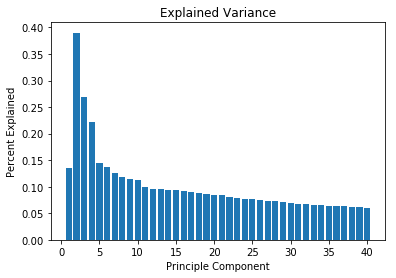

In [90]:
plt.bar(list(range(1, number_of_principle_components+1)), percent_explained_variance_features)
plt.xlabel('Principle Component')
plt.ylabel('Percent Explained')
plt.title('Explained Variance')

In [91]:
cum_sum_explained_variance = np.cumsum(percent_explained_variance_features)
cum_sum_explained_variance

array([ 0.13598576,  0.52609061,  0.7950278 ,  1.01632323,  1.16095418,
        1.29830253,  1.42377435,  1.54200339,  1.65626492,  1.76903933,
        1.86915564,  1.96568121,  2.06163297,  2.15630142,  2.24956796,
        2.34063574,  2.4309923 ,  2.51842868,  2.60486646,  2.68942717,
        2.77325695,  2.85392784,  2.93244573,  3.00966285,  3.08604258,
        3.16047985,  3.23443364,  3.30707647,  3.37853691,  3.44784787,
        3.5152019 ,  3.58228698,  3.64861963,  3.713823  ,  3.77769351,
        3.84145482,  3.904359  ,  3.96668491,  4.02858523,  4.08879442])

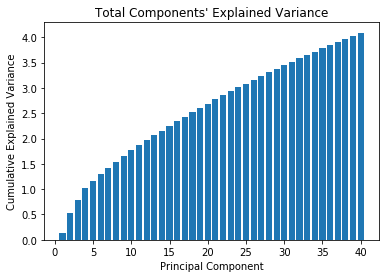

In [92]:
plt.bar(list(range(1, number_of_principle_components+1)), cum_sum_explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title("Total Components' Explained Variance")

Our SVD (of 40 latent features) only explains ~4% of variance of the data. There's a huge amount of variance over our millions of Hacker News comments because topics range from business, to programming, to science and nearly everything else. Therefore, ~4% is fairly reasonable. If we were using data for fairly homogenous documents, we'd expect the sum of our components to explain much closer to 100% variance.

## Clustering

The Hacker News comments data set doesn't have labels. It's an instructured data set and we're trying to make meaning/structure out of it by grouping documents based on their features and features' values (Tfidf weights) 

Intertia is the sum of square distances in each cluster. A low inertia value = high density of points of observations around the center of its cluster. More clusters likely equates to a lower inertia value for our KMeans model. If we fit our model multiple times, we'd get slightly different inertia values. We want to minimize our inertia values for a given number of clusters.

We want to find a good estimate for the number of clusters we should utilize for a KMeans model. To do this, let's plot our inertia values over several values of clusters. We're looking for the elbow in the plot - the point of diminishing inertia values for each additional cluster.

However, upon implementing the code below, I had massive fluctuations in inertia with each incremental number of clusters. The problem with using inertia is that it doesn't penalize for additional number of clusters. Generally, we want fewer clusters in order to easily make understandable groups.

In [93]:
# inertia_values = []
# range_of_K_values = range(1, 25)
# for num_clusters in range_of_K_values:
#     kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', max_iter=100, n_init=1, n_jobs=-1)
#     kmeans.fit(X)
#     inertia_values.append(kmeans.inertia_)

# inertia_values

# # graph inertia over number of clusters
# plt.plot(list(range_of_K_values), inertia_values)
# plt.xlabel('Number of Clusters')
# plt.ylabel('Kmeans Inertia')
# plt.title('Cluster Density')

Instead, I tested out various number of clusters - from 8 to 25. I found 20 clusters to be optimal. At 20 clusters, I noticed clusters that revealed words across documents that were within the scope of documents on Hacker News - for words around programming languages, tech companies, code, etc. 

For example, one cluster may talk about "app, microsoft, linux" while another "free, open, open source" and another "money, market, uber". 

I tried out many combinations of clusters smaller than 20, but couldn't glean major differences between clusters with generic words such as "work, time, great". These words could be associated with nearly any forum site; however, Hacker News is generally more tech/science/business oriented so I cared more about words in these clusters.

‘k-means++’ selects initial cluster centers for KMeans clustering in a smart way to speed up convergence. This is especially helpful as we have high dimensionality data.

[sklearn documentation on KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)

In [94]:
number_of_clusters = 20
km = KMeans(n_clusters=number_of_clusters, init='k-means++', max_iter=100, n_init=1, n_jobs=-1)

I also tried getting the silhouette score (below). That can be considered a good metric to help identify your optimal number of clusters. However, I couldn't get it to work as my Kernal would die everytime. I believe 200K samples is outside the performance capable of this algorithm to get silhouette scores.

[sklearn documentation on silhouette score](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)

In [95]:
# X.shape
# predicted_labels = km.fit_predict(X)
# predicted_labels.shape
# predicted_labels[0:100]
# set(predicted_labels)
# silhouette_avg = silhouette_score(X, predicted_labels)

We already did fit_transform above with SVD to get our new matrix shape that contains our 40 latent samentic features. Here, we can simply fit our data to our KMeans model.

In [96]:
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=20, n_init=1, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

km.cluster_centers_ takes coordinates of cluster centers

svd.inverse_transform transforms the dataset of cluster centers back to the corresponding dataset before SVD truncatation (which is after Tfidf vectorizing). So we have the Tfidf weights as values in our matrix

We have 20 clusters, and 40 latent semantic features. So each cluster has coordinates in 40-dimensional space.

In [97]:
km.cluster_centers_.shape

(20, 40)

In [98]:
km.cluster_centers_[0]

array([ 0.39620947, -0.119902  , -0.05627003,  0.014505  ,  0.03419883,
        0.02918329,  0.04877089,  0.07289593, -0.07694694, -0.02672751,
       -0.16119874, -0.01501859, -0.00937057, -0.07997836, -0.05260556,
        0.24681106,  0.03055058,  0.03311661, -0.05080965,  0.03037132,
       -0.03740265, -0.148166  ,  0.05908974,  0.40807326, -0.09541083,
       -0.03822647, -0.15304457,  0.01979978, -0.03672623,  0.04611517,
       -0.00622793, -0.00368075,  0.04702796,  0.01673997,  0.0061776 ,
       -0.02864281, -0.03912132,  0.01664593, -0.02237636, -0.02151007])

.argsort returns the indices that would sort the array from its smallest values to largest

[numpy documentation on argsort](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=0ahUKEwiWj6fNhJbUAhUGRiYKHVeWA0sQFggoMAA&url=https%3A%2F%2Fdocs.scipy.org%2Fdoc%2Fnumpy%2Freference%2Fgenerated%2Fnumpy.argsort.html&usg=AFQjCNEIZw-eAurbq7M8XJpjdmaPTFdxtw&sig2=192Af96YCi6cKgajcMVOCQ)

[:, ::-1] gets all values from list, starting at highest index

So order_centroids returns us rows as cluster values - with each value being the largest Tfidf values for that cluster

In [99]:
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

In [100]:
order_centroids[0:10]

array([[77403, 63074, 77627, ..., 31738, 11357, 28664],
       [80739, 35330, 81294, ..., 66131, 74608, 37681],
       [31609, 31688, 11069, ..., 83059, 79039, 83056],
       ..., 
       [58348, 35736, 39161, ..., 11357, 30996, 40386],
       [75796, 35736, 76336, ..., 82384, 11357, 83059],
       [79118,  5760, 28664, ..., 31820, 74608, 69761]])

In [101]:
order_centroids.shape

(20, 83175)

We want to get the feature names after the Tfidf vectorizer

In [102]:
terms = vectorizer.get_feature_names()

In [103]:
print("Top terms per cluster by Tfidf ranking:")
for i in range(number_of_clusters):
    print("Cluster %d:" % i, end='')
    print(" ")
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end='')  # print phrases in clusters
        print("")
    print(" ")
    print(" ")
print()

Top terms per cluster by Tfidf ranking:
Cluster 0: 
 ve
 seen
 ve seen
 got
 used
 heard
 ve heard
 years
 just
 read
 did
 actually
 things
 ve got
 like
 people
 lot
 don
 using
 probably
 
 
Cluster 1: 
 work
 job
 working
 day
 company
 doesn
 time
 people
 just
 hours
 like
 doing
 need
 hard
 way
 lot
 home
 does
 think
 pay
 
 
Cluster 2: 
 http
 http www
 com
 www
 org
 news
 html
 article
 like
 uk
 net
 blog
 data
 app
 just
 way
 did
 https www
 doesn
 people
 
 
Cluster 3: 
 money
 uber
 company
 pay
 market
 companies
 business
 tax
 new
 cost
 year
 make
 price
 government
 free
 service
 going
 car
 high
 product
 
 
Cluster 4: 
 does
 google
 code
 thanks
 yes
 data
 years
 source
 did
 article
 language
 doesn
 mean
 want
 open
 read
 make
 need
 ago
 thank
 
 
Cluster 5: 
 like
 looks
 sounds
 looks like
 sounds like
 things
 look
 feel
 way
 things like
 don
 just
 feel like
 lot
 make
 thing
 new
 just like
 doesn
 look like
 
 
Cluster 6: 
 windows
 using
 app
 lin

### Clarification of Clusters

All the documents that typically have the words in a cluster are likely to be clustered together. But this doesn't detail anything about distances between words in documents. So we still don't know the meaning of these words or in what context they're used in sentences.

___

What about other types clustering models?

[sklearn documentation on agglomerative clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

Hierarchical clustering (broader strategy of agglomerative clustering) is 0*n^2*log(n) which makes this operation too slow for large dataset such as mine..

My HN comments are often very dissimilar so I don't think cosinse similarity would be very helpful.

DBScan and Mini Batch KMeans both work well with a large number of samples. I could try those and compare results of clusters.

[sklearn documentation on DBScan](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

[sklearn documentation on Mini Batch K Means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html)

Lessons learned: DBScan took an incredibly long amount of time to run. It may not be best for my large number of samples - especially because I'd want to utilize grid search on DBScan to optimally find clusters and can't without GPUs or a higher performance computer.

Mini Batch K Means is incredibly fast! 

In [104]:
mini_batch_kmeans = MiniBatchKMeans(init='k-means++', init_size=1000,
                                   batch_size=200)

In [105]:
mini_batch_kmeans.fit(X)

MiniBatchKMeans(batch_size=200, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=8,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [106]:
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

In [107]:
terms = vectorizer.get_feature_names()

In [108]:
print("Top terms per cluster by Tfidf ranking:")
for i in range(number_of_clusters):
    print("Cluster %d:" % i, end='')
    print(" ")
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end='')  # print phrases in clusters
        print("")
    print(" ")
    print(" ")
print()

Top terms per cluster by Tfidf ranking:
Cluster 0: 
 ve
 seen
 ve seen
 got
 used
 heard
 ve heard
 years
 just
 read
 did
 actually
 things
 ve got
 like
 people
 lot
 don
 using
 probably
 
 
Cluster 1: 
 work
 job
 working
 day
 company
 doesn
 time
 people
 just
 hours
 like
 doing
 need
 hard
 way
 lot
 home
 does
 think
 pay
 
 
Cluster 2: 
 http
 http www
 com
 www
 org
 news
 html
 article
 like
 uk
 net
 blog
 data
 app
 just
 way
 did
 https www
 doesn
 people
 
 
Cluster 3: 
 money
 uber
 company
 pay
 market
 companies
 business
 tax
 new
 cost
 year
 make
 price
 government
 free
 service
 going
 car
 high
 product
 
 
Cluster 4: 
 does
 google
 code
 thanks
 yes
 data
 years
 source
 did
 article
 language
 doesn
 mean
 want
 open
 read
 make
 need
 ago
 thank
 
 
Cluster 5: 
 like
 looks
 sounds
 looks like
 sounds like
 things
 look
 feel
 way
 things like
 don
 just
 feel like
 lot
 make
 thing
 new
 just like
 doesn
 look like
 
 
Cluster 6: 
 windows
 using
 app
 lin

Ultimately, these clusters included words that often didn't appear as top words in other clusters. Therefore, they were fairly distinguished from one another. The only issue is that clustering used a bag of words approach. So words like "use", "like" and "master" are vague because I don't know in what context they appeared. There are certainly better ways we can get insights from these Hacker News comments.

___

## Topic Extraction

### LDA

Latent Dirichlet Allocation (LDA) is a way of discovering topics that documents contain. You pass, as a parameter, a value for the number of topics you want to create. 

LDA is a learning model.

With each topic, you can see words and probabilities associated with seeing each of those words across all the Hacker News comments. You don't get an exact topic name; but based on words like "computer, python and java", you can infer the topic is about computer programming.

Great [Quora post on LDA](https://www.quora.com/What-is-a-good-explanation-of-Latent-Dirichlet-Allocation)

[SKlearn documentation on LDA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)

I tried using LDA through SKlearn but the process took a very long time and never finished. Instead, I've heard Gensim is much better performance-wise.

[Gensim documentation on LDA](https://radimrehurek.com/gensim/models/ldamodel.html)

With LDA, we map text documents from a word space to a topic space - that gives us the topic distribution of different documents in our corpus; it also allows us to make conceptual comparisions of documents in this reduced topic space.

#### Topic Modeling with Gensim

We transpose our Count Vectorizer matrix so the terms are rows

In [109]:
counts = count_vect_matrix.transpose()

In [110]:
counts.shape

(83175, 246175)

We need to convert our sparse scipy matrix to a gensim-friendly objected called a Corpus.

In [111]:
corpus = matutils.Sparse2Corpus(counts)

In [112]:
type(corpus)

gensim.matutils.Sparse2Corpus

The term "flying car" is at feature index 25052

In [113]:
count_vectorizer.vocabulary_['flying car']

25052

We need to save a mapping (dict) of row id to word (token) for later use by gensim. We call the variable id2word but that can include bigrams - as seen above in "flying car"

In [114]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [115]:
len(id2word)

83175

Create our LDA model. It requires our corpus of word counts, mapping of row ids to words, and the number of topics. 

We're doing unsupervised learning so there's no perfect answer on the number of topics we need. I'll start with 15.

In [116]:
# Create lda model (equivalent to "fit" in sklearn)
# passes is the max value to keep on iterating until we converge
lda = models.LdaModel(corpus=corpus, num_topics=15, id2word=id2word, passes=1)

2017-06-05 20:56:09,339 : INFO : using symmetric alpha at 0.06666666666666667
2017-06-05 20:56:09,340 : INFO : using symmetric eta at 1.20228434025e-05
2017-06-05 20:56:09,356 : INFO : using serial LDA version on this node
2017-06-05 20:56:15,417 : INFO : running online LDA training, 15 topics, 1 passes over the supplied corpus of 246175 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2017-06-05 20:56:15,451 : INFO : PROGRESS: pass 0, at document #2000/246175
2017-06-05 20:56:18,249 : INFO : merging changes from 2000 documents into a model of 246175 documents
2017-06-05 20:56:18,444 : INFO : topic #10 (0.067): 0.005*"really" + 0.005*"way" + 0.005*"just" + 0.004*"https" + 0.004*"use" + 0.004*"com" + 0.003*"want" + 0.003*"like" + 0.003*"time" + 0.003*"right"
2017-06-05 20:56:18,446 : INFO : topic #7 (0.067): 0.006*"just" + 0.005*"like" + 0.005*"https" + 0.004*"don" + 0.004*"people" + 

Let's see the 100 most important words for each of the topics. Below, we see the top probabilities of words that would appear in this topic. 

In [117]:
lda.print_topics(num_words = 100)

2017-06-05 21:01:29,212 : INFO : topic #0 (0.067): 0.008*"companies" + 0.008*"uber" + 0.008*"cost" + 0.008*"company" + 0.008*"market" + 0.008*"business" + 0.006*"price" + 0.006*"people" + 0.006*"car" + 0.005*"long" + 0.004*"money" + 0.004*"tech" + 0.004*"tip" + 0.004*"high" + 0.004*"just" + 0.004*"self" + 0.004*"going" + 0.004*"buy" + 0.003*"term" + 0.003*"costs" + 0.003*"quality" + 0.003*"point" + 0.003*"small" + 0.003*"drivers" + 0.003*"probably" + 0.003*"big" + 0.003*"make" + 0.003*"model" + 0.003*"driving" + 0.003*"low" + 0.003*"industry" + 0.003*"cars" + 0.003*"tesla" + 0.003*"expensive" + 0.003*"time" + 0.003*"years" + 0.003*"like" + 0.003*"ve" + 0.003*"new" + 0.003*"million" + 0.003*"risk" + 0.002*"startup" + 0.002*"cheap" + 0.002*"prices" + 0.002*"stock" + 0.002*"supply" + 0.002*"large" + 0.002*"sell" + 0.002*"customers" + 0.002*"service" + 0.002*"value" + 0.002*"worth" + 0.002*"sales" + 0.002*"profit" + 0.002*"short" + 0.002*"startups" + 0.002*"businesses" + 0.002*"cheaper" + 

[(0,
  '0.008*"companies" + 0.008*"uber" + 0.008*"cost" + 0.008*"company" + 0.008*"market" + 0.008*"business" + 0.006*"price" + 0.006*"people" + 0.006*"car" + 0.005*"long" + 0.004*"money" + 0.004*"tech" + 0.004*"tip" + 0.004*"high" + 0.004*"just" + 0.004*"self" + 0.004*"going" + 0.004*"buy" + 0.003*"term" + 0.003*"costs" + 0.003*"quality" + 0.003*"point" + 0.003*"small" + 0.003*"drivers" + 0.003*"probably" + 0.003*"big" + 0.003*"make" + 0.003*"model" + 0.003*"driving" + 0.003*"low" + 0.003*"industry" + 0.003*"cars" + 0.003*"tesla" + 0.003*"expensive" + 0.003*"time" + 0.003*"years" + 0.003*"like" + 0.003*"ve" + 0.003*"new" + 0.003*"million" + 0.003*"risk" + 0.002*"startup" + 0.002*"cheap" + 0.002*"prices" + 0.002*"stock" + 0.002*"supply" + 0.002*"large" + 0.002*"sell" + 0.002*"customers" + 0.002*"service" + 0.002*"value" + 0.002*"worth" + 0.002*"sales" + 0.002*"profit" + 0.002*"short" + 0.002*"startups" + 0.002*"businesses" + 0.002*"cheaper" + 0.002*"cash" + 0.002*"long term" + 0.002*"p

New LDA-learned topics after regex:
- Workplace banter (like, life, look, old, human, time, world, women, years)
- Talks on open knowledge (read, article, source, open, open source, book, community)
- Data talk (gooogle, data, ai, deep, intelligence, research, networks, connection, model)
- Software performance (memory, speed, size, math, module, infinite, papers, hash)
- Programming languages (code, language, java, programming, javascript, js, python, api, rust)
- Macro business/govt (wikipedia, government, countries, income, taxes, power, state, country, capital)
- Changes in history (years, ago, city, years ago, new, later, america, times, land, happened)
- Big software platforms (linux, windows, app, software, web, android, microsoft, aws)
- 'Uber' effect (money, cost, uber, market, car, problem, service, self, driving, drivers, tesla)
- Generic remarks (point, better, things, great, experiment, best, question, answers)
- Code management (data, user, image, file, server, computer, browser, linear, kernel, source
- Government (law, government, legal, private, public, policy, issue, patent, trust, trump)
- Job/family concerns (people, work, want, job, money, culture, problem, poor, family)
- Popular website links/attachments (github, google, pdf, post, page, dropbox, reddit, gitlab)
- Job search (experience, interview, learning, school, great, company, years, skills, whiteboard, startup, technical, questions)

This topics above are very insightful! Many have common buzzwords I've heard about the topics on Hacker News or from friends - but it's cool to all see them in one place!

The LDA and clustering used simple bag of words approaches - so we don't know the context of words in sentences. So when we heard words like "good", "bad" and "cars", we don't know exactly what people generally associate cars with. Let's try to make conceptual comparisions between blocks of text.

**Word2vec**
can create context windows like five-grams
we need to assign each word or bigram an index from 0 - V  (v being # distinct words in corpus)
Inputs: middle word
Output: other words of context window

Skip grams:
We're trying to predict the words around a word.

Continuous bag of words:
given several words, can we predict the one-word associated with it

In [118]:
stop = set(['heh', 'wow', 'hah', 'hey', 'yeah','wtf', 'meh', 'oops', 'nah', 'yea','doesnt','dont',
   'huh', 'mar', 'umm', 'like', 'think', 'duh', 'sigh', 'wheres', 'hmm','interesting','article',
   'say', 'hello', 'yup','im', 'ltsarcasmgt', 'hehe', 'blah', 'nope', 'ouch', 'uh'] + stopwords.words('english'))

In [119]:
len(stop)

186

In [120]:
df_type_comments['split_comment_words'] = df_type_comments['text'].str.lower().str.split()

/Users/dan/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [121]:
texts = []

for comment in df_type_comments.split_comment_words:
    new_comment = []
    for word in comment:
        if word in stop:
            pass  # we don't want to include this stop word
        else:
            new_comment.append(word)
    texts.append(new_comment)

In [122]:
word_two_vec = models.Word2Vec(texts, size=200, window=4, min_count=10, workers=4, sg=1)

2017-06-05 21:01:38,173 : INFO : collecting all words and their counts
2017-06-05 21:01:38,175 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-06-05 21:01:38,262 : INFO : PROGRESS: at sentence #10000, processed 331136 words, keeping 53803 word types
2017-06-05 21:01:38,348 : INFO : PROGRESS: at sentence #20000, processed 673855 words, keeping 85612 word types
2017-06-05 21:01:38,435 : INFO : PROGRESS: at sentence #30000, processed 985195 words, keeping 110268 word types
2017-06-05 21:01:38,526 : INFO : PROGRESS: at sentence #40000, processed 1323020 words, keeping 133862 word types
2017-06-05 21:01:38,622 : INFO : PROGRESS: at sentence #50000, processed 1667684 words, keeping 156219 word types
2017-06-05 21:01:38,729 : INFO : PROGRESS: at sentence #60000, processed 2006941 words, keeping 175991 word types
2017-06-05 21:01:38,823 : INFO : PROGRESS: at sentence #70000, processed 2335266 words, keeping 194175 word types
2017-06-05 21:01:38,923 : INFO : PROG

In [123]:
type(word_two_vec)

gensim.models.word2vec.Word2Vec

In [124]:
print(word_two_vec.similarity('elon','tesla'))

0.642901638534


### Let's try some pair-wise comparisons! 

In [125]:
words_with_linkedin = ['nice', "helpful", "awesome", "jobs", 'good', 'bad', 'spam', 'advertising', 'ads', "ad", 'spam', "recruit", 'job', 'network', 'founder']

for word in words_with_linkedin:
    similarity = word_two_vec.similarity('linkedin', word)
    print("{0} and linkedin: {1}".format(word, similarity))

nice and linkedin: 0.20239235462425015
helpful and linkedin: 0.3876046858402107
awesome and linkedin: 0.3498346593234357
jobs and linkedin: 0.29799666052627405
good and linkedin: 0.24090598433809327
bad and linkedin: 0.23487223532511387
spam and linkedin: 0.5632705948911862
advertising and linkedin: 0.3759218337755161
ads and linkedin: 0.3505997308576099
ad and linkedin: 0.35901339131943133
spam and linkedin: 0.5632705948911862
recruit and linkedin: 0.5795595281831671
job and linkedin: 0.35215434476566415
network and linkedin: 0.25516178153332936
founder and linkedin: 0.49163205187247555


In [126]:
words_with_thiel = ['nice', 'good', 'bad', 'job', 'network', 'founder', 'fund', 'college']

for word in words_with_thiel:
    similarity = word_two_vec.similarity('thiel', word)
    print("{0} and thiel: {1}".format(word, similarity))

nice and thiel: 0.19632102680414576
good and thiel: 0.24903499217676953
bad and thiel: 0.2511811258988722
job and thiel: 0.20755877484129787
network and thiel: 0.13711916392128082
founder and thiel: 0.5909898758604776
fund and thiel: 0.32248024521926766
college and thiel: 0.3060743308021644


In [139]:
words_with_tesla = ['cat', 'cars', "mars", "musk", 'car', 'self', 'three', '3', 'model', 'spacex', 'elon', 'electric', 'vehicle']

for word in words_with_tesla:
    similarity = word_two_vec.similarity('tesla', word)
    print("{0} and tesla: {1}".format(word, similarity))

cat and tesla: 0.21505069992285658
cars and tesla: 0.5988400836137333
mars and tesla: 0.3775405114799705
musk and tesla: 0.6253844894378401
car and tesla: 0.5526767085173219
self and tesla: 0.38478363577643027
three and tesla: 0.03963286818319984
3 and tesla: 0.23641768562017917
model and tesla: 0.3328042240316319
spacex and tesla: 0.6253956259353688
elon and tesla: 0.6429016385343611
electric and tesla: 0.601355724488056
vehicle and tesla: 0.5609685808100657


In [128]:
words_with_data = ['science', 'machine', "ai", "deep", "neural", "network", "learning", "model", "warehouse"]

for word in words_with_data:
    similarity = word_two_vec.similarity('data', word)
    print("{0} and data: {1}".format(word, similarity))

science and data: 0.1616682181523955
machine and data: 0.30986394282397633
ai and data: 0.21883042231688965
deep and data: 0.17386263496158044
neural and data: 0.25426244585394137
network and data: 0.2575073539589451
learning and data: 0.21901204020162834
model and data: 0.23399699345593594
warehouse and data: 0.31522597025306526


In [129]:
words_with_uber = ['cars', "drivers", "driver", "taxi", 'car', 'self', 'travis', 'lyft', 'share']

for word in words_with_uber:
    similarity = word_two_vec.similarity('uber', word)
    print("{0} and uber: {1}".format(word, similarity))

cars and uber: 0.4613491189487633
drivers and uber: 0.5660130195233564
driver and uber: 0.5198409876794874
taxi and uber: 0.6967426203582391
car and uber: 0.4399795883843042
self and uber: 0.344473022757424
travis and uber: 0.4635756352604215
lyft and uber: 0.7824413043944751
share and uber: 0.19054697015758365


In [130]:
words_with_apple = ['cars', 'self', 'steve', 'jobs', 'ios', 'android', 'google', 'linux', 'os', 'mac']

for word in words_with_apple:
    similarity = word_two_vec.similarity('apple', word)
    print("{0} and apple: {1}".format(word, similarity))

cars and apple: 0.27135330351255105
self and apple: 0.22822908757019206
steve and apple: 0.411437767835246
jobs and apple: 0.16086889934329113
ios and apple: 0.5704511588097121
android and apple: 0.5176579568782066
google and apple: 0.44813559423265015
linux and apple: 0.3587924070906193
os and apple: 0.4633175147944112
mac and apple: 0.5665887571861825


With these pair-wise comparisions, we get a better understanding of 